## Import Libraries

In [1]:
import boto3,re,time
import sagemaker
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timezone
from smexperiments.trial import Trial
from smdebug.trials import create_trial
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from smexperiments.experiment import Experiment
from smexperiments.trial_component import TrialComponent
from sagemaker import HyperparameterTuningJobAnalytics, Session
from smexperiments.search_expression import Filter, Operator, SearchExpression
from sagemaker.tuner import HyperparameterTuner, ContinuousParameter, IntegerParameter
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig

[2021-05-04 15:19:14.753 TIGER070:357 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [8]:
#sagemaker_session = sagemaker.LocalSession()
sagemaker_session = sagemaker.Session()

# Get a SageMaker-compatible role used by this Notebook Instance.
#role = get_execution_role()
iam = boto3.client('iam')
role = iam.get_role(RoleName='aws-sagemaker-access')['Role']['Arn']

processed_train_data = 's3://aws-sagemaker-one/datasets/pre-processed-input/processed_train_data.csv'
processed_test_data = 's3://aws-sagemaker-one/datasets/pre-processed-input/processed_test_data.csv'

In [3]:
## Downloading xgboost container
region = boto3.Session().region_name
container = sagemaker.image_uris.retrieve('xgboost', region, version ="0.90-2")
display(container)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


'257758044811.dkr.ecr.us-east-2.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3'

## Creating XG Boost Estimator

In [4]:
bucket = 'aws-sagemaker-one'
prefix = 'datasets'

In [5]:
## Input and Validation Data 
content_type = "text/csv"
s3_input_train = TrainingInput(s3_data='s3://{}/{}/pre-processed-input/processed_train_data.csv'.format(bucket, prefix), content_type='csv')
s3_input_validation = TrainingInput(s3_data='s3://{}/{}/pre-processed-input/processed_test_data.csv'.format(bucket, prefix), content_type='csv')

In [6]:
xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session = sagemaker_session)

In [7]:
xgb.set_hyperparameters(min_child_weight=6,
                        subsample=0.8,
                        eval_metric='rmse'
                        )

hyperparameter_ranges = {'max_depth' : IntegerParameter(2, 4),
                         'eta' : ContinuousParameter(.2, .9),
                         'gamma' : ContinuousParameter(2, 3),
                         'num_round' : IntegerParameter(2, 6)}

objective_metric_name = 'validation:rmse'

## Create Hyperparameter Tuning Job

In [8]:
tuner = HyperparameterTuner(estimator = xgb,
                            objective_metric_name = objective_metric_name,
                            objective_type = 'Minimize',
                            hyperparameter_ranges = hyperparameter_ranges,
                            tags = [{'Key':'aws-training','Value':'assignment-3'}],
                            max_jobs = 20,
                            max_parallel_jobs = 10,
                            strategy = 'Random'
                           )

In [9]:
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False)

INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-xgboost-210504-1519


.......................................................................................................!


## Associate the Tuning Job to Sagemaker Experiment

In [13]:
# Get the most recently created tuning job
sess = boto3.Session()
sm = sess.client("sagemaker")

list_tuning_jobs_response = sm.list_hyper_parameter_tuning_jobs(
    SortBy="CreationTime", SortOrder="Descending"
)
print(f'Found {len(list_tuning_jobs_response["HyperParameterTuningJobSummaries"])} tuning jobs.')
tuning_jobs = list_tuning_jobs_response["HyperParameterTuningJobSummaries"]
most_recently_created_tuning_job = tuning_jobs[0]
tuning_job_name = most_recently_created_tuning_job["HyperParameterTuningJobName"]
experiment_name = "xgboost-experiment-final-with-tuning-jobs"
trial_name = tuning_job_name + "-trial"

print(
    f"Associate all training jobs created by {tuning_job_name} with trial {trial_name}"
)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


Found 7 tuning jobs.
Associate all training jobs created by sagemaker-xgboost-210504-1519 with trial sagemaker-xgboost-210504-1519-trial


## Get the trial components derived from the training jobs

In [14]:
# Get the trial components derived from the training jobs

creation_time = most_recently_created_tuning_job["CreationTime"]
creation_time = creation_time.astimezone(timezone.utc)
creation_time = creation_time.strftime("%Y-%m-%dT%H:%M:%SZ")

created_after_filter = Filter(
    name="CreationTime",
    operator=Operator.GREATER_THAN_OR_EQUAL,
    value=str(creation_time),
)

# the training job names contain the tuning job name (and the training job name is in the source arn)
source_arn_filter = Filter(
    name="TrialComponentName", operator=Operator.CONTAINS, value=tuning_job_name
)
source_type_filter = Filter(
    name="Source.SourceType", operator=Operator.EQUALS, value="SageMakerTrainingJob"
)

search_expression = SearchExpression(
    filters=[created_after_filter, source_arn_filter, source_type_filter]
)

# search iterates over every page of results by default
trial_component_search_results = list(
    TrialComponent.search(search_expression=search_expression, sagemaker_boto_client=sm)
)

print(f"Found {len(trial_component_search_results)} trial components.")

Found 20 trial components.


In [15]:
print("Creating experiment with name: ", experiment_name )
experiment = Experiment.create(experiment_name=experiment_name)
trial = Trial.create(experiment_name=experiment_name, trial_name=trial_name)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


Creating experiment with name:  xgboost-experiment-final-with-tuning-jobs


INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


## Creating Trials from trial components

In [16]:
# associate the trial components with the trial
for tc in trial_component_search_results:
    print(
        f"Associating trial component {tc.trial_component_name} with trial {trial.trial_name}."
    )
    trial.add_trial_component(tc.trial_component_name)
    # sleep to avoid throttling
    time.sleep(0.5)

Associating trial component sagemaker-xgboost-210504-1519-016-0dd7bf72-aws-training-job with trial sagemaker-xgboost-210504-1519-trial.
Associating trial component sagemaker-xgboost-210504-1519-020-d3f9ad4e-aws-training-job with trial sagemaker-xgboost-210504-1519-trial.
Associating trial component sagemaker-xgboost-210504-1519-019-2becaa56-aws-training-job with trial sagemaker-xgboost-210504-1519-trial.
Associating trial component sagemaker-xgboost-210504-1519-015-591039d4-aws-training-job with trial sagemaker-xgboost-210504-1519-trial.
Associating trial component sagemaker-xgboost-210504-1519-017-df186f79-aws-training-job with trial sagemaker-xgboost-210504-1519-trial.
Associating trial component sagemaker-xgboost-210504-1519-013-3606a12a-aws-training-job with trial sagemaker-xgboost-210504-1519-trial.
Associating trial component sagemaker-xgboost-210504-1519-018-c67563ed-aws-training-job with trial sagemaker-xgboost-210504-1519-trial.
Associating trial component sagemaker-xgboost-21

## Selecting the best model

In [17]:
## Selected the best model using sagemaker console
best_trial_component_name = 'sagemaker-xgboost-210504-1519-017-df186f79-aws-training-job'
best_trial_component = TrialComponent.load(best_trial_component_name)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [18]:
#estimator = Estimator.attach(best_trial_component.source.source_arn.split("/")[-1])
#best_model = estimator.create_model(env={'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT':"text/csv"})
best_trial_component.source.source_arn.split("/")[-1]

'sagemaker-xgboost-210504-1519-017-df186f79'

In [23]:
import os
output_path= 's3://{}/{}/output'.format(bucket, prefix)
model_path = 'output/model.tar.gz'

best_model_s3 = os.path.join(output_path,best_trial_component.source.source_arn.split("/")[-1],model_path)

In [29]:
best_model_s3

's3://aws-sagemaker-one/datasets/output/sagemaker-xgboost-210504-1519-017-df186f79/output/model.tar.gz'

## Create Debugger Config using Best Model

In [106]:
save_interval = 1

debugger_hook_config = DebuggerHookConfig(
                       s3_output_path='s3://{}/{}/debugger'.format(bucket, prefix),
                       collection_configs=[ CollectionConfig(
                                                name="metrics",
                                                parameters={
                                                "save_interval": str(save_interval)
                                                }
                                            ),
                                            CollectionConfig(
                                                name="feature_importance",
                                                parameters={
                                                "save_interval": str(save_interval)
                                                }
                                            ),
                                            CollectionConfig(
                                                name="full_shap",
                                                parameters={
                                                "save_interval": str(save_interval)
                                                }
                                            ),
                                            CollectionConfig(
                                                name="average_shap",
                                                parameters={
                                                "save_interval": str(save_interval)
                                                }
                                            ),
                                        ],
                                    )

loss_not_decreasing_rule = Rule.sagemaker(
                                base_config=rule_configs.loss_not_decreasing(),
                                rule_parameters={
                                            "collection_names": "metrics",
                                            "num_steps": str(save_interval * 2),
                                              }
                           )

overfit_rule = Rule.sagemaker(
                    base_config=rule_configs.overfit()
)

xgboost_estimator = Estimator( 
                    image_uri = container,
                    base_job_name='xgboost-estimator-final',
                    role=role,
                    instance_count=1, 
                    instance_type='ml.m4.xlarge',
                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                    sagemaker_session = sagemaker_session,
                    debugger_hook_config = debugger_hook_config,
                    rules=[loss_not_decreasing_rule, overfit_rule]
                    )

In [107]:
## Get the parameters from the best tuning job
best_trial_component.parameters

{'SageMaker.ImageUri': '257758044811.dkr.ecr.us-east-2.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3',
 'SageMaker.InstanceCount': 1.0,
 'SageMaker.InstanceType': 'ml.m4.xlarge',
 'SageMaker.VolumeSizeInGB': 30.0,
 '_tuning_objective_metric': 'validation:rmse',
 'eta': 0.6802458111450536,
 'eval_metric': 'rmse',
 'gamma': 2.645259419883189,
 'max_depth': 4.0,
 'min_child_weight': 6.0,
 'num_round': 6.0,
 'subsample': 0.8}

In [108]:
xgboost_estimator.set_hyperparameters(eta=best_trial_component.parameters['eta'],
                                      gamma=best_trial_component.parameters['gamma'],
                                      max_depth=int(best_trial_component.parameters['max_depth']),
                                      min_child_weight=int(best_trial_component.parameters['min_child_weight']),
                                      num_round=int(best_trial_component.parameters['num_round']),
                                      subsample=best_trial_component.parameters['subsample'],
                                      eval_metric=best_trial_component.parameters['eval_metric']
                                      )

In [109]:
xgboost_estimator.fit({'train': s3_input_train, 'validation': s3_input_validation})

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: xgboost-estimator-final-2021-05-04-12-28-14-271


2021-05-04 12:28:16 Starting - Starting the training job...
2021-05-04 12:28:41 Starting - Launching requested ML instances
********* Debugger Rule Status *********
*
*  LossNotDecreasing: InProgress        
*            Overfit: InProgress        
*
****************************************
......
2021-05-04 12:30:01 Starting - Preparing the instances for training......
2021-05-04 12:31:01 Downloading - Downloading input data...
2021-05-04 12:31:42 Training - Downloading the training image...
2021-05-04 12:32:13 Uploading - Uploading generated training model
2021-05-04 12:32:13 Completed - Training job completed
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value rmse to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined de

## Performance metrics

In [110]:
from smdebug.trials import create_trial
s3_output_path = xgboost_estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2021-05-04 18:03:53.875 TIGER070:357 INFO s3_trial.py:42] Loading trial debug-output at path s3://aws-sagemaker-one/datasets/debugger/xgboost-estimator-final-2021-05-04-12-28-14-271/debug-output


In [111]:
trial.tensor("train-rmse").values()

[2021-05-04 18:03:59.502 TIGER070:357 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2021-05-04 18:04:00.788 TIGER070:357 INFO trial.py:210] Loaded all steps


{0: array([100881.851562]),
 1: array([69180.914062]),
 2: array([61690.207031]),
 3: array([56921.164062]),
 4: array([55839.199219]),
 5: array([54616.039062])}

In [112]:
trial.tensor("validation-rmse").values()

{0: array([95879.820312]),
 1: array([71185.460938]),
 2: array([68631.929688]),
 3: array([66308.820312]),
 4: array([66974.203125]),
 5: array([66264.140625])}

In [113]:
def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()

    tensors = trial.collection(collection_name).tensor_names

    for tensor_name in sorted(tensors):
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            ax.plot(steps, data, label=tensor_name)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

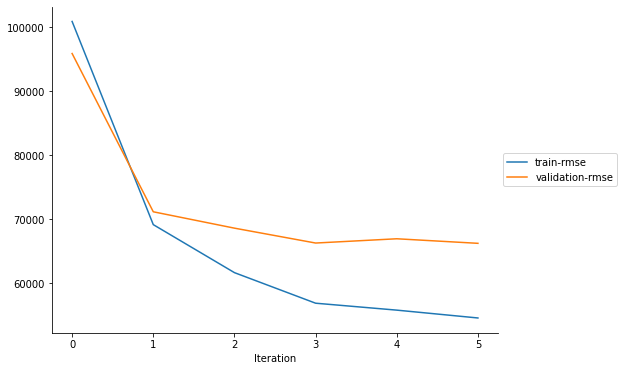

In [114]:
plot_collection(trial, "metrics")

## Feature Importance - weight

In [115]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*")

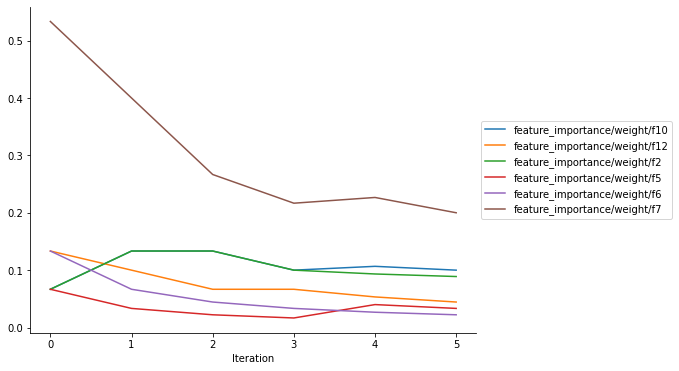

In [116]:
plot_feature_importance(trial)

## Feature Importance - cover

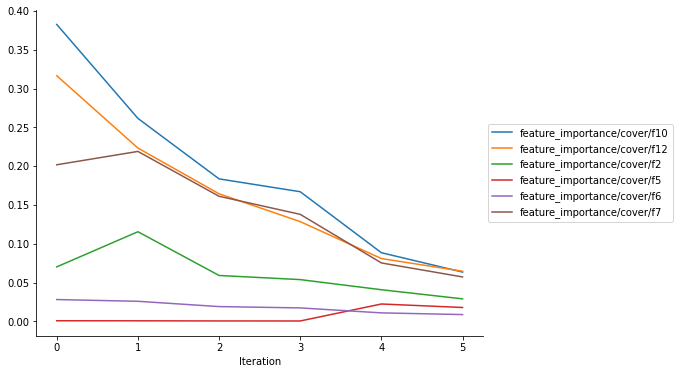

In [117]:
plot_feature_importance(trial, importance_type="cover")

## SHAP Plots

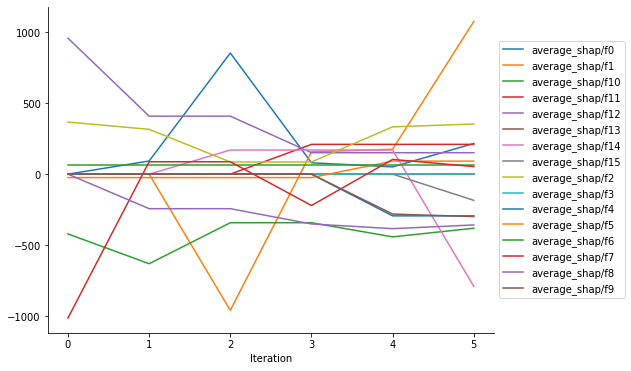

In [118]:
plot_collection(trial,"average_shap")

## Global Explanations

In [10]:
feature_names = [ 'longitude',
                  'latitude',
                  'housing_median_age',
                  'total_rooms',
                  'total_bedrooms',
                  'population',
                  'households',
                  'median_income',
                  'rooms_per_household',
                  'population_per_household',
                  'bedrooms_per_room',
                  '<1H OCEAN',
                  'INLAND',
                  'ISLAND',
                  'NEAR BAY',
                  'NEAR OCEAN']

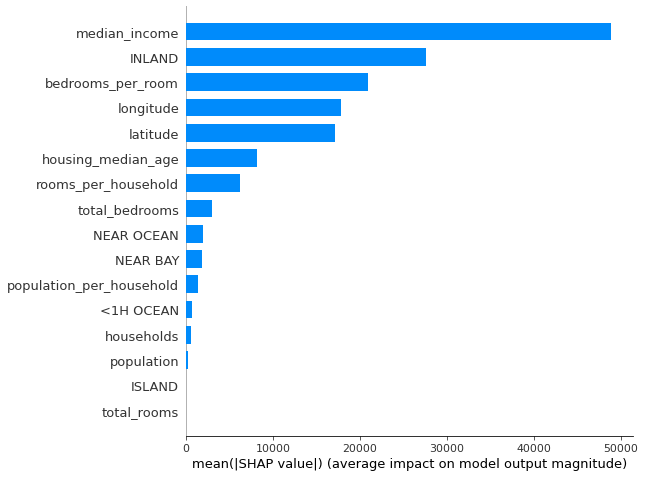

In [123]:
import shap

shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type='bar', feature_names=feature_names)

## Local Explanations

In [169]:
processed_train_data

's3://aws-sagemaker-one/datasets/pre-processed-input/processed_train_data.csv'

In [11]:
import pandas as pd

data = pd.read_csv(processed_train_data,header=None)
data.columns = ['median_house_value'] + feature_names

In [172]:
len(data.columns)

17

In [173]:
data.shape

(16512, 17)

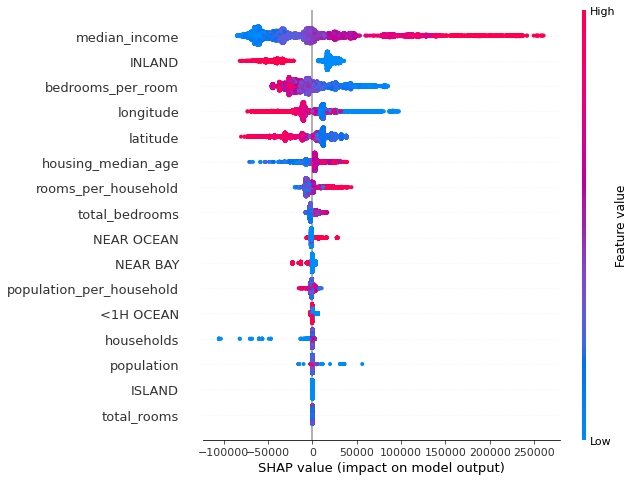

In [174]:
shap.summary_plot(shap_no_base, data[['longitude', 'latitude', 'housing_median_age',
       'total_rooms', 'total_bedrooms', 'population', 'households',
       'median_income', 'rooms_per_household', 'population_per_household',
       'bedrooms_per_room', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY',
       'NEAR OCEAN']], feature_names=feature_names)

## Local Explanations for a record

In [4]:
shap.initjs()

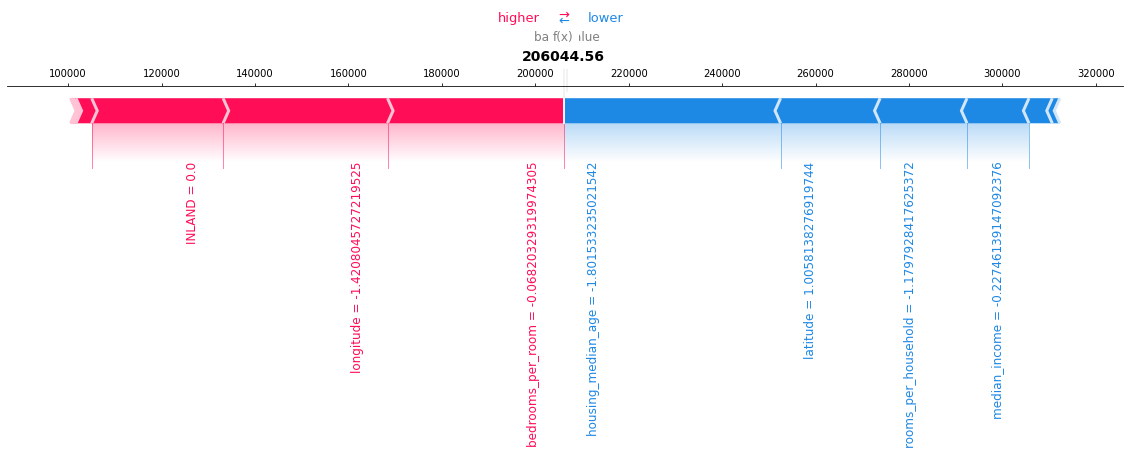

In [177]:
shap.force_plot(shap_base_value, shap_no_base[100,:], data[['longitude', 'latitude', 'housing_median_age',
       'total_rooms', 'total_bedrooms', 'population', 'households',
       'median_income', 'rooms_per_household', 'population_per_household',
       'bedrooms_per_room', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY',
       'NEAR OCEAN']].iloc[100,:], link="identity", matplotlib=True, text_rotation=90, figsize =(20,3))

## Stacked Force Plot

In [14]:
N_ROWS = shap_no_base.shape[0]
N_SAMPLES = min(100, N_ROWS)
sampled_indices = np.random.randint(N_ROWS, size=N_SAMPLES)

In [15]:
shap.force_plot(shap_base_value,
                shap_no_base[sampled_indices,:],
                data[['longitude', 'latitude', 'housing_median_age',
               'total_rooms', 'total_bedrooms', 'population', 'households',
               'median_income', 'rooms_per_household', 'population_per_household',
               'bedrooms_per_room', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY',
               'NEAR OCEAN']].iloc[sampled_indices,:],
                link="identity")

## Outlier Plot

In [183]:
from scipy import stats

N_OUTLIERS = 3

shap_sum = np.sum(shap_no_base, axis=1)
z_scores = stats.zscore(shap_sum)
outlier_indices = (np.argpartition(z_scores, -N_OUTLIERS)[-N_OUTLIERS:]).tolist()
outlier_indices += (np.argpartition(z_scores, N_OUTLIERS)[:N_OUTLIERS]).tolist()

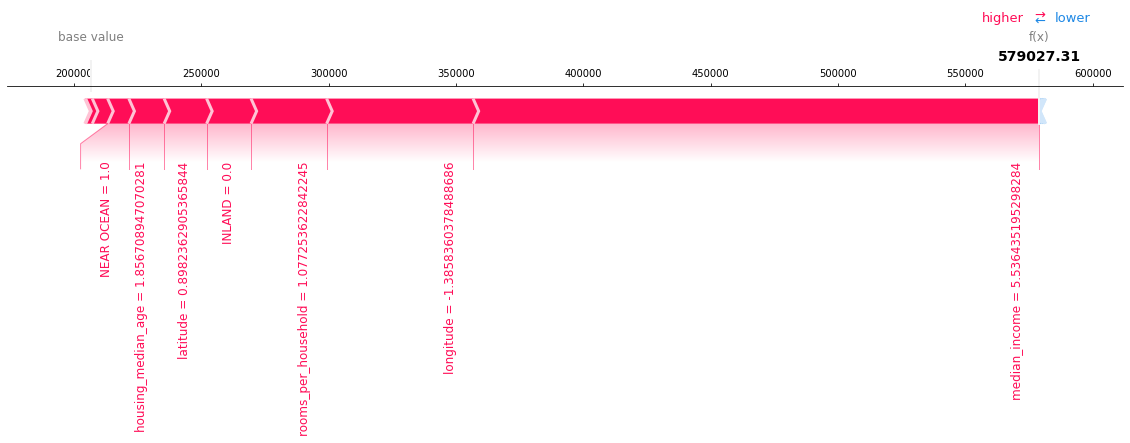

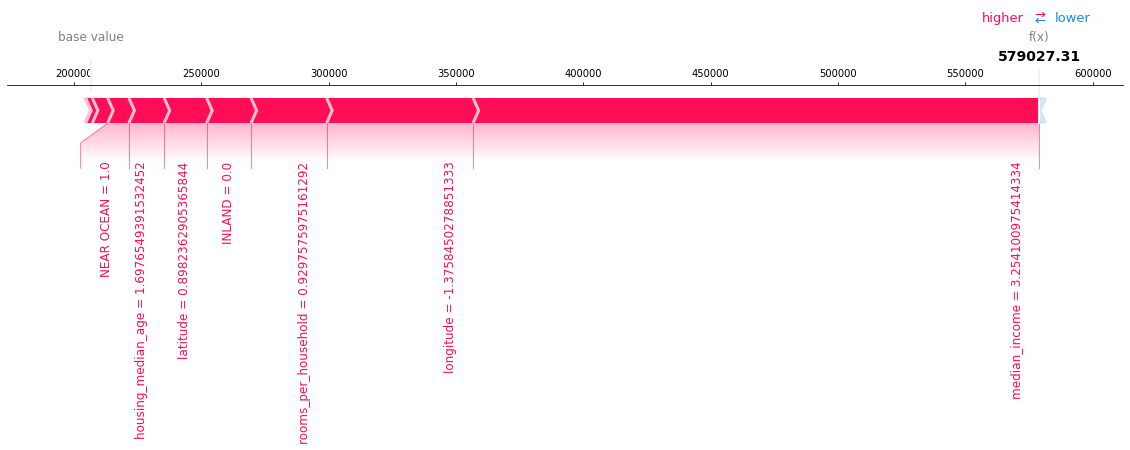

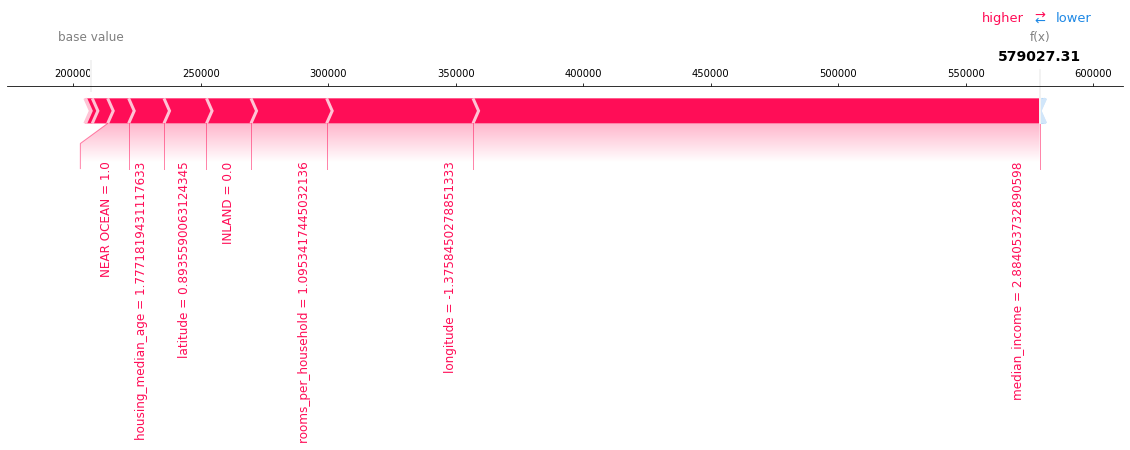

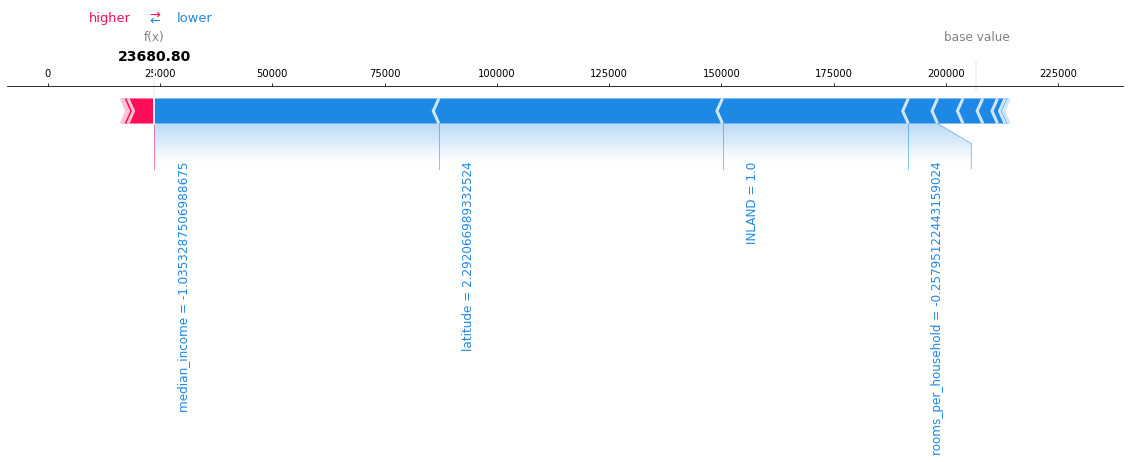

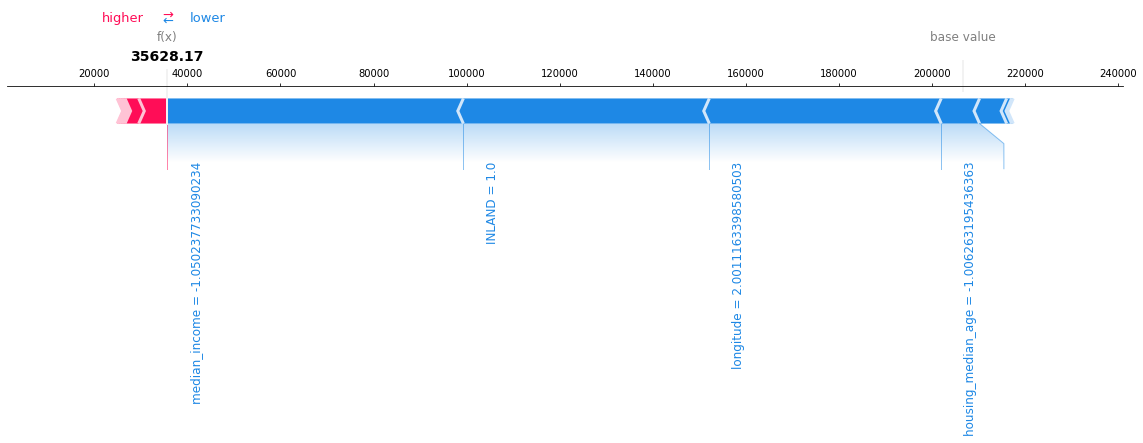

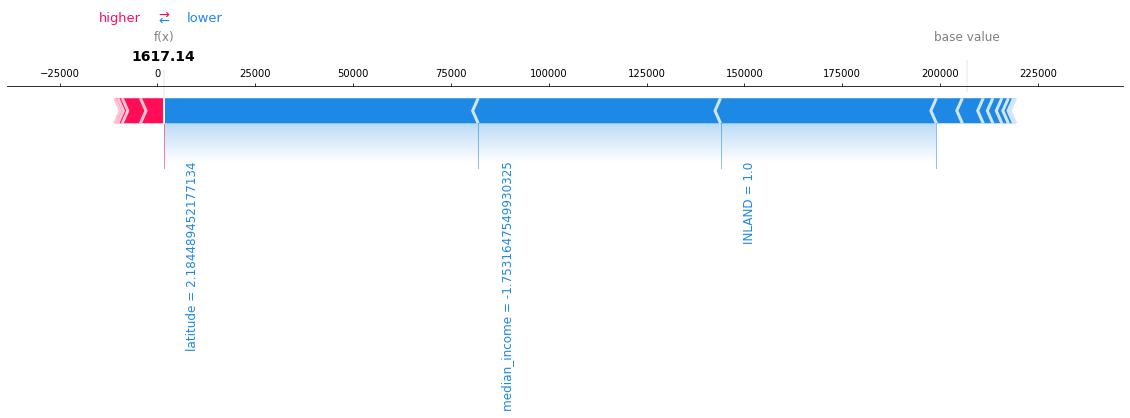

In [184]:
for fig_index, outlier_index in enumerate(outlier_indices, start=1):
    shap.force_plot(shap_base_value,
                    shap_no_base[outlier_index,:],
                    data[['longitude', 'latitude', 'housing_median_age',
                   'total_rooms', 'total_bedrooms', 'population', 'households',
                   'median_income', 'rooms_per_household', 'population_per_household',
                   'bedrooms_per_room', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY',
                   'NEAR OCEAN']].iloc[outlier_index,:],
                    matplotlib=True,
                    link="identity",
                    text_rotation=90, figsize =(20,3))

## Deploy the Best Model

In [185]:
from sagemaker.model import Model
from sagemaker.pipeline import PipelineModel
import boto3
from time import gmtime, strftime

timestamp_prefix = strftime("%Y-%m-%d-%H-%M-%S", gmtime())

xgboost_inference_model = xgboost_estimator.create_model()

model_name = 'xgboost-inference-pipeline-' + timestamp_prefix
endpoint_name = 'xgboost-inference-pipeline-ep-' + timestamp_prefix

#sm_model.sagemaker_session=None

xgboost_inference_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge', endpoint_name=endpoint_name)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2021-05-04-13-07-24-425
INFO:sagemaker:Creating endpoint with name xgboost-inference-pipeline-ep-2021-05-04-13-07-23


----------------!

## Make a request to the Endpoint

In [188]:
from sagemaker.predictor import json_serializer, csv_serializer, json_deserializer, Predictor
#from sagemaker.content_types import CONTENT_TYPE_CSV, CONTENT_TYPE_JSON

csv_serializer = sagemaker.serializers.CSVSerializer(content_type="text/csv")
data = "-1.1760248286103931,0.6596947951050618,-1.165317203353399,-0.9089665536785813,-1.036927797035715,-0.998331346653321,-1.0222270483369085,1.336459363533279,0.217683376839971,-0.8362890162005467,-0.03353391294213801,1,0,0,0,0"
#123900.0,0.05786490191116035,0.5942128159669972,-1.3243712112704347,0.16707479417158205,-0.094925858095718,-0.2113479135278657
#-0.18115162421384587,0.020216703326492513,0.5766685354769602,-0.7283977507490025,-0.029050139829962122,0,1,0,0,0


predictor = Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sagemaker_session,
    serializer=csv_serializer)


print(predictor.predict(data))

b'313515.75'


## Delete the Endpoint

In [189]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: xgboost-inference-pipeline-ep-2021-05-04-13-07-23
INFO:sagemaker:Deleting endpoint with name: xgboost-inference-pipeline-ep-2021-05-04-13-07-23
